# MULTICLASS CLASSIFICATION ON FULL SLICE IMAGES

## LOADING DATA


In [1]:
import SimpleITK as sitk
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "/kaggle/input/dataset-csv/dataset_lung.xlsx"
data = pd.read_excel(csv_path)

data.head()

,Full_slice,Nodule,TumorClass
0,pat1_fullslice.nrrd,pat1_nodule.nrrd,5
1,pat2_fullslice.nrrd,pat2_nodule.nrrd,5
2,pat3_fullslice.nrrd,pat3_nodule.nrrd,2
3,pat4_fullslice.nrrd,pat4_nodule.nrrd,5
4,pat5_fullslice.nrrd,pat5_nodule.nrrd,4


In [2]:
#function to load the images in the database
def load_nrrd(file_path):
    """Load an NRRD file using SimpleITK."""

    train_loc = '/kaggle/input/test-dataset/Train'
    
    file_path = os.path.join(train_loc, file_path)
    image = sitk.ReadImage(file_path)
    array = sitk.GetArrayFromImage(image)  # Convert to NumPy array
    return array

CARICO I DATI

In [3]:
#non carico no 'nodules' così ci mette di meno

data_loaded = False
if not data_loaded:
    images = data['Full_slice']       #immagine CT
    images = images.apply(load_nrrd)

    #nodules = data['Nodule']         #nodulo
    #nodules = nodules.apply(load_nrrd)

    labels = data['TumorClass']     #labels
    
    print(images[0].shape)#, nodules[0].shape)
    print(images[1].shape)#, nodules[1].shape)
    print(images[2].shape)#, nodules[2].shape)
    print(images[3].shape)#, nodules[3].shape)

    np.savez("new_dataset", images=images, labels=labels) #, nodules=nodules) #salvo in un nuovo dataset
    
else:
    path = ''
    data = np.load(path)
    images = data['images']
    labels = data['labels']
    #nodules = data['nodules']

(512, 512)
(512, 512)
(512, 512)
(512, 512)


**IMAGES HAVE ALL THE SAME DIMENSION**

In [23]:
from collections import Counter
#vedo il numero di sample per ogni classe (1,2,3,4,5)

label_counts = Counter(labels)
print(label_counts)

Counter({3: 1092, 2: 457, 4: 418, 1: 244, 5: 152})


**CLASSES DISTRIBUTION IS HIGLT IMBALANCED**

## EXPLORATORY DATA ANALYSIS

## WINDOW SELECTION (Considering HU values for Lung images)

In [24]:
W = 1300
L = -220

v_min = L - W/2
v_max = L + W/2

0.0 255.0


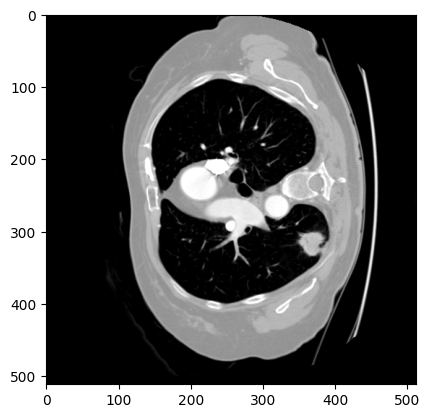

In [25]:
img_window = np.clip(images[0], a_min=v_min, a_max=v_max)
img_rescaled = (img_window - v_min)/W * 255
plt.imshow(img_rescaled, cmap='gray')
print(img_rescaled.min(), img_rescaled.max())

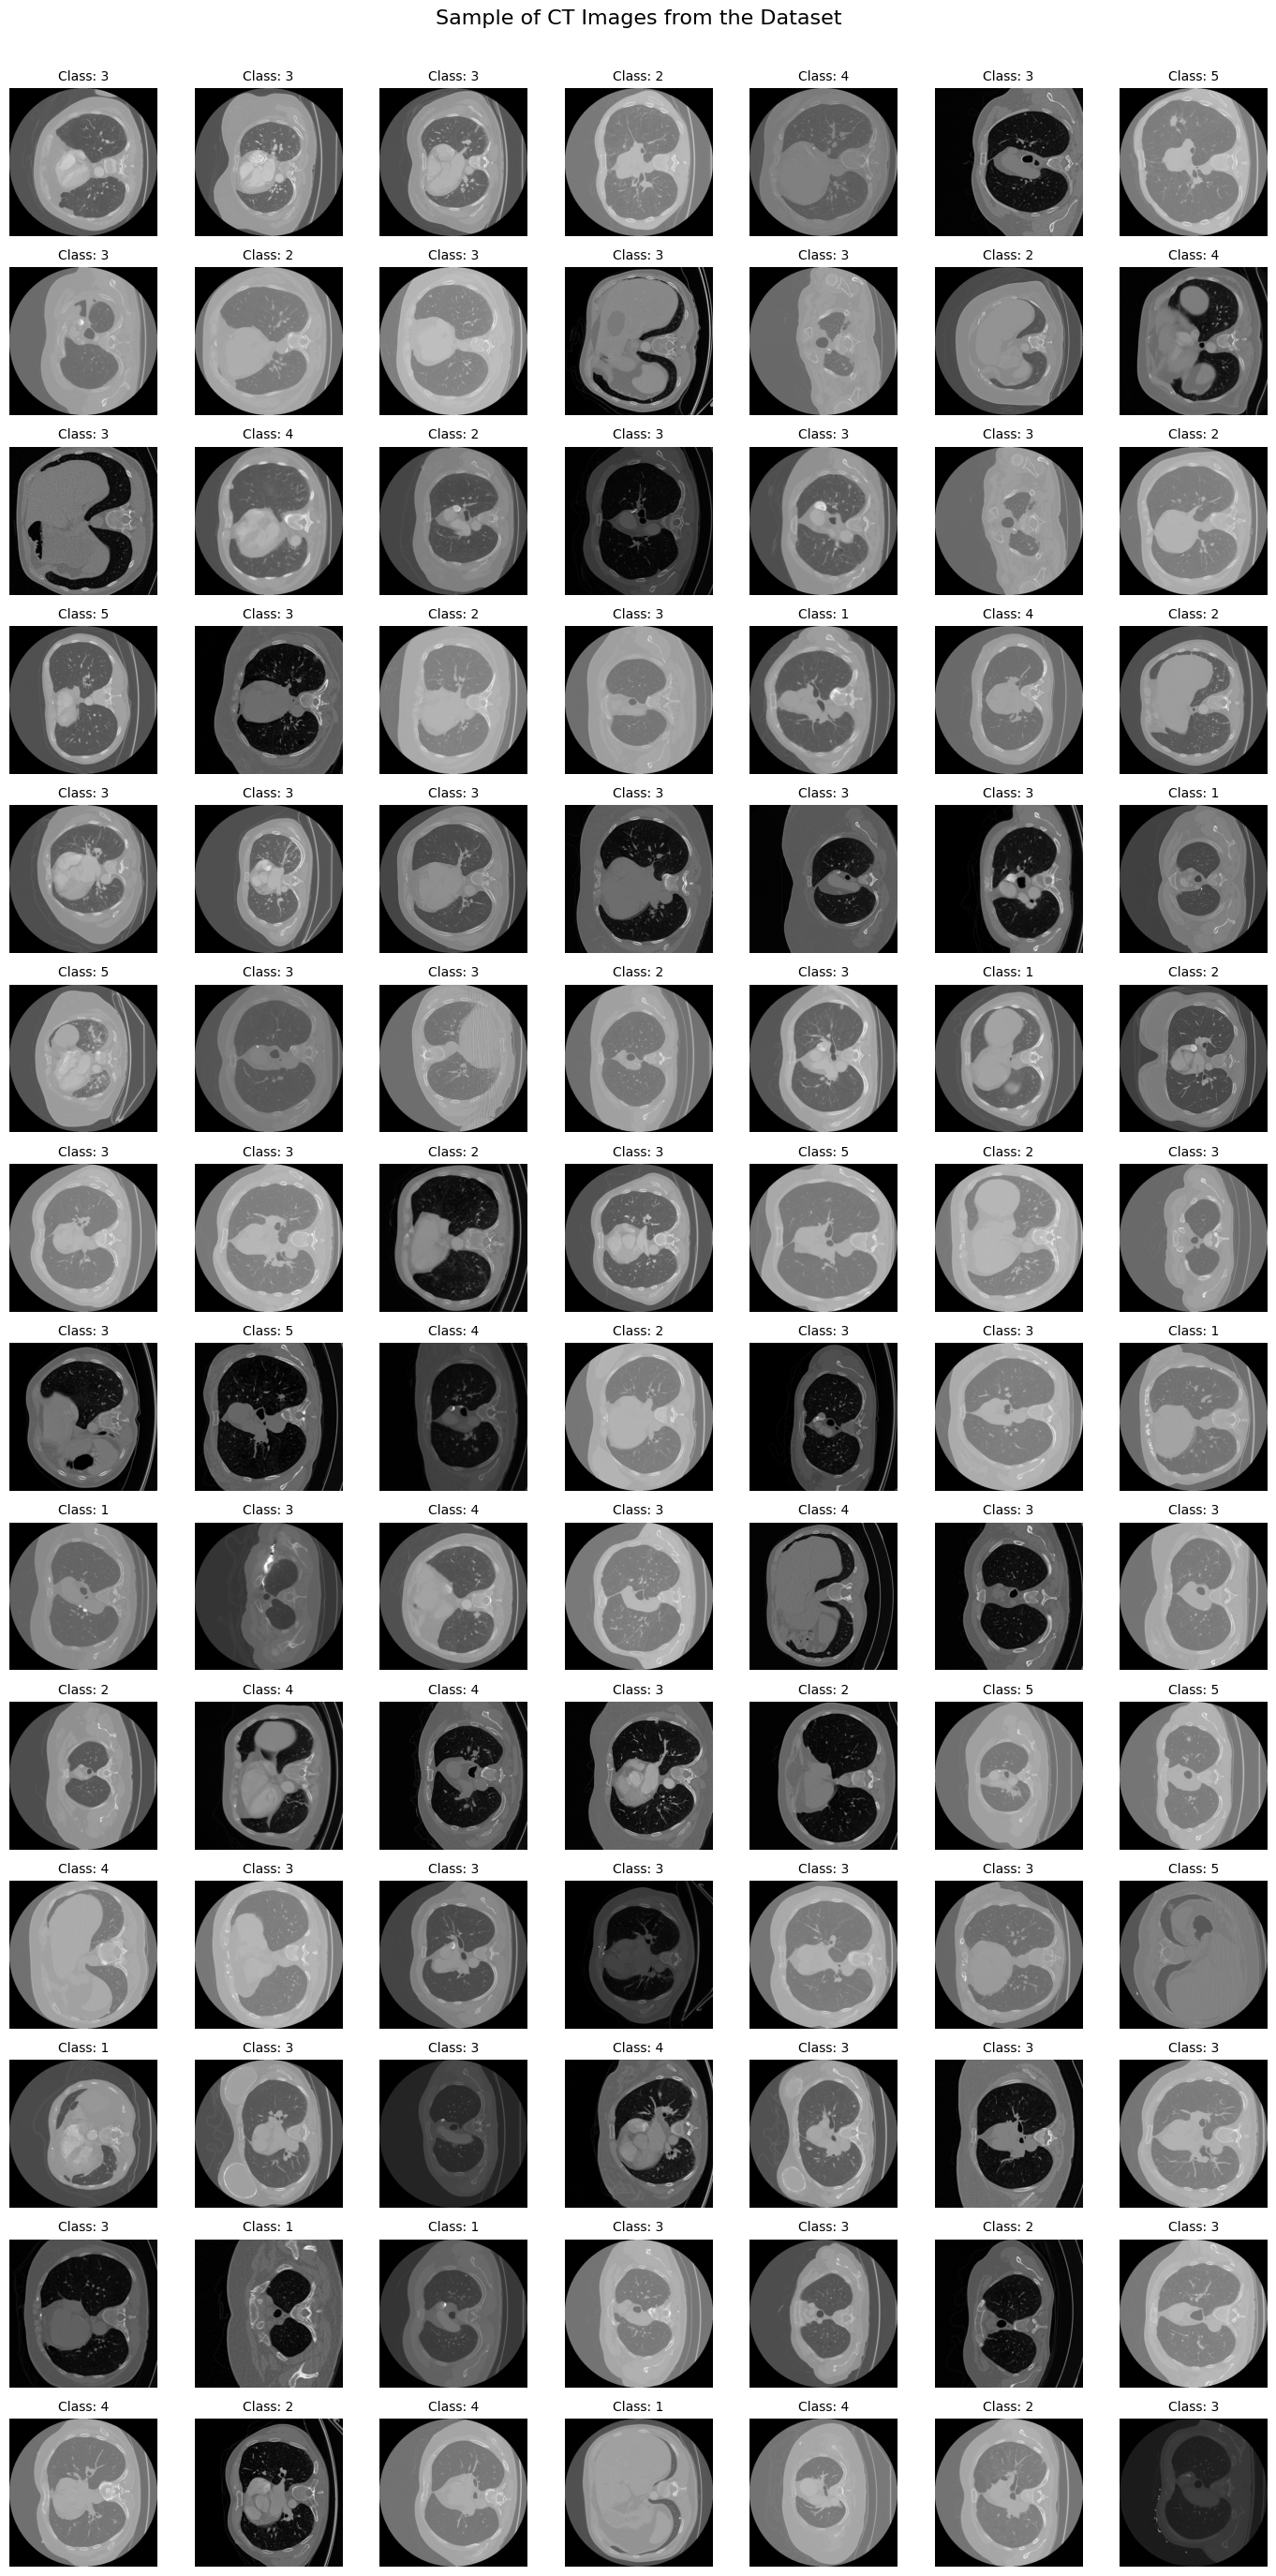

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(images, labels, num_images=100, cols=7):
    """
    Funzione per visualizzare un campione di immagini con le rispettive classi.
    
    - images: array delle immagini originali (assunto shape: (N, H, W) o (N, H, W, C))
    - labels: array delle etichette corrispondenti
    - num_images: numero di immagini da visualizzare (default: 100)
    - cols: numero di colonne nella griglia (default: 7)
    """
    rows = num_images // cols  # Numero di righe
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))  # Imposta la dimensione della figura
    fig.suptitle("Sample of CT Images from the Dataset", fontsize=16)  # Titolo generale
    
    indices = np.random.choice(len(images), num_images, replace=False)  # Seleziona immagini casuali
    
    for i, ax in enumerate(axes.flat):
        idx = indices[i]
        img = images[idx].squeeze()  # Rimuove eventuali canali extra se è in scala di grigi
        ax.imshow(img, cmap='gray')  # Mostra l'immagine in scala di grigi
        ax.set_title(f"Class: {labels[idx]}", fontsize=10)  # Titolo con la classe
        ax.axis("off")  # Nasconde gli assi

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Distanza dal titolo
    plt.show()

# Esegui la funzione per visualizzare le immagini dal dataset iniziale
plot_sample_images(images, labels, num_images=100, cols=7)

## RESHAPE to 240x240 (adapting to the model preferencies)

In [27]:
import cv2

new_shape = (240, 240)
new_images = np.zeros((images.shape[0], new_shape[0], new_shape[1])) # [N, 224, 224] standard ResNet format
new_labels = np.zeros(images.shape[0]) - 1

print(new_images.shape)
for i, im in enumerate(images.copy()):

    img_window = np.clip(im, a_min=v_min, a_max=v_max)
    img = (img_window - v_min)/W * 255
    
    img = cv2.resize(img, new_shape) # resize to new shape
    # img = np.stack((img, img, img), axis=-1)
    
    new_images[i] = img
    new_labels[i] = labels[i]

new_labels = new_labels.astype(int)
new_labels = new_labels-1

(2363, 240, 240)


In [29]:
print(np.unique(new_labels))
print("Range new_images:", new_images.min(), new_images.max())

[0 1 2 3 4]
Range new_images: 0.0 255.0


## CLASS OCCURENCES

[0 1 2 3 4] [ 244  457 1092  418  152]


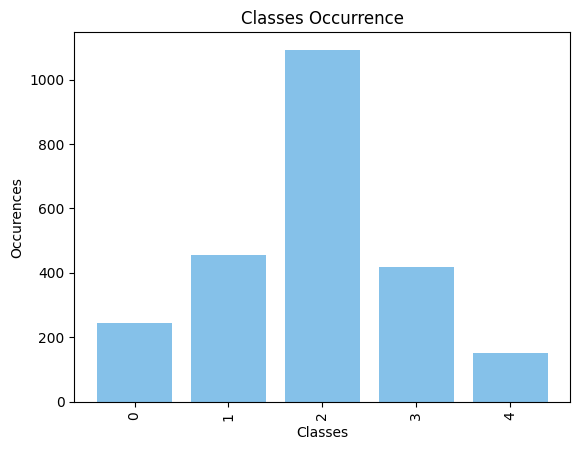

In [30]:
classes_names_bin, counts_bin = np.unique(new_labels, return_counts=True)

print(classes_names_bin, counts_bin)

#for plotting we can use plt.bar function for example
plt.bar(x=classes_names_bin,height=counts_bin, facecolor ='#85c1e9')
plt.title("Classes Occurrence", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

## GREYSCALE TO RGB (model wants 3 channel images)

In [31]:

new_images_3channels = np.zeros((new_images.shape[0], new_shape[0], new_shape[1], 3)) # [N, 224, 224] standard ResNet format

for i, im in enumerate(new_images.copy()):
    img = np.stack((im, im, im), axis=-1)
    new_images_3channels[i] = img

In [32]:
print(new_images_3channels.shape)
print("Range new_images_3channels:", new_images_3channels.min(), new_images_3channels.max())

(2363, 240, 240, 3)
Range new_images_3channels: 0.0 255.0


## SPLIT TRAIN, VALIDATION, TEST

In [8]:
from sklearn.model_selection import train_test_split

X = new_images_3channels
y = new_labels

X_d, X_test, y_d, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_d, y_d, test_size=0.1, stratify=y_d, random_state=42)

# mean = X_train.mean()
# std = X_train.std()

# # normalizing according to the TRAIN mean and STD
# X_train = (X_train - mean)/std
# X_valid = (X_valid - mean)/std
# X_test = (X_test - mean)/std

print("Original dataset size di train:", X_train.shape, "Labels of train:", np.bincount(y_train))

Original dataset size di train: (1701, 240, 240, 3) Labels of train: [175 329 786 301 110]


## BALANCING TRAIN SET BY UPSAMPLING TECHNIQUE

In [33]:
#SOLO UPSAMPLING
from sklearn.utils import resample
import numpy as np

# Trova il numero di campioni per ciascuna classe
class_counts = np.bincount(y_train)  # Conta i campioni per ogni classe
max_count = np.max(class_counts)  # Trova la classe con il numero massimo di campioni

# Crea liste per accumulare i nuovi indici bilanciati
balanced_indices = []

# Applica oversampling a ogni classe
for class_label in range(len(class_counts)):  
    class_indices = np.where(y_train == class_label)[0]  # Trova gli indici di questa classe
    
    if len(class_indices) < max_count:
        # Oversampling per la classe minoritaria
        oversampled_indices = resample(class_indices,
                                       replace=True,  
                                       n_samples=max_count,  # Porta la classe al numero massimo di campioni
                                       random_state=42)
    else:
        # Se la classe ha già il massimo numero di campioni, non serve oversampling
        oversampled_indices = class_indices
    
    balanced_indices.append(oversampled_indices)

# Concatena tutti gli indici e mescola il dataset
balanced_indices = np.concatenate(balanced_indices)
np.random.shuffle(balanced_indices)

# Crea il dataset bilanciato
X_train_bal = X_train[balanced_indices]
y_train_bal = y_train[balanced_indices]

print("Balanced dataset size:", X_train_bal.shape)
print("Class distribution after balancing:", np.bincount(y_train_bal))

Balanced dataset size: (3930, 240, 240, 3)
Class distribution after balancing: [786 786 786 786 786]


In [34]:
X_train = X_train_bal
y_train = y_train_bal 
print(np.unique(y_train_bal))

[0 1 2 3 4]


## DEFINING FOCAL LOSS

In [9]:
def focal_loss(alpha=0.5, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])  # Converti in one-hot
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)  # Evita log(0)
        loss = -alpha * y_true * ((1 - y_pred) ** gamma) * tf.math.log(y_pred)
        return tf.reduce_sum(loss, axis=-1)
    return loss


## TRAIN DATA GENERATOR & MODEL ARCHITECTURE DEFINITION

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow.keras as tfk
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers as tfkl
from tensorflow.keras import regularizers, activations
from tensorflow import keras
import tensorflow.keras.layers as tfkl
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)
X_test = preprocess_input(X_test)


# Data Augmentation
train_data_generator = ImageDataGenerator(
                                    #rescale=1/255,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=(0.9,1.1),
                                    brightness_range=(0.9,1.1),
                                    horizontal_flip=False)
                                    


#validation_data_generator = ImageDataGenerator(rescale=1/255)
#test_data_generator = ImageDataGenerator(rescale=1/255)

# Fit the data generators
train_data_generator.fit(X_train)
#validation_data_generator.fit(X_valid)
#test_data_generator.fit(X_test)

# Create Data Generators
train_generator = train_data_generator.flow(X_train, y_train, batch_size=16, shuffle=True)


#EfficientNetB1
base_model = EfficientNetB1(weights='imagenet', input_shape=(240, 240, 3), include_top=False, pooling='avg')

base_model.trainable = True 


# model definition
inputs = tf.keras.Input(shape=(240, 240, 3), name='input_layer')

# Connect resnet50 to the input
x = base_model(inputs)

x = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='dense1')(x)#, kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01))(x)
x = tfkl.Dropout(0.5, name='dropout1')(x)
x = tfkl.BatchNormalization(name='batchnorm1')(x)
x = tfkl.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='dense2')(x)
x = tfkl.Dropout(0.4, name='dropout2')(x)
x = tfkl.BatchNormalization(name='batchnorm2')(x)

# Output Layer 
outputs = tfkl.Dense(5, activation='softmax', name='dense3')(x)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=focal_loss(alpha=0.5, gamma=2.0),  
    #loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## MODEL TRAINING

In [ ]:
# Define Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=1e-7)


# Train the model 
history = model.fit(
    train_generator,
    validation_data=(X_valid, y_valid),
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
)


# Print final validation accuracy
final_val_accuracy = max(history.history['val_accuracy']) * 100
print(f'Final validation accuracy: {final_val_accuracy:.2f}%')

## MODEL PERFORMANCES

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history.history['loss'], label='Training loss', alpha=.8)
plt.plot(history.history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history.history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history.history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


# Step 1: Ottieni le previsioni del modello
y_pred_prob = model.predict(X_valid)  # Probabilità delle classi
y_pred = np.argmax(y_pred_prob, axis=1)  # Classe predetta

# Step 2: Calcola l'AUC per ogni classe (se multi-classe)
try:
    y_valid_one_hot = tf.keras.utils.to_categorical(y_valid)  # Conversione a one-hot
    auc = roc_auc_score(y_valid_one_hot, y_pred_prob, average='macro', multi_class='ovr')
    print(f"AUC macro-averaged: {auc:.4f}")
except ValueError as e:
    print(f"Impossibile calcolare AUC: {e}")

# Step 3: Calcola la confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Step 4: Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_valid))
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Step 2: Calcola Precision, Recall, F1-score e Accuracy per classe
report = classification_report(y_valid, y_pred, target_names=[f"Class {i}" for i in np.unique(y_valid)])
print("Classification Report:\n")
print(report)

In [ ]:
model.save('/kaggle/working/model_5class_CT1.h5')

## MONTE CARLO DROPOUT TECHINQUE (confidence interval estimation)

In [35]:
from tensorflow.keras.models import load_model

# Definizione della loss (stessa definizione usata durante il training)
def focal_loss(alpha=0.5, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])  # Converti in one-hot
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)  # Evita log(0)
        loss = -alpha * y_true * ((1 - y_pred) ** gamma) * tf.math.log(y_pred)
        return tf.reduce_sum(loss, axis=-1)
    return loss

# Caricare il modello specificando la funzione personalizzata
model = load_model('/kaggle/input/modello/tensorflow2/default/1/model_5class_CT1.h5', custom_objects={"loss": focal_loss(alpha=0.5, gamma=2.0)})
print("✅ Modello caricato correttamente!")

model.trainable = False
model.get_layer('dropout2').trainable=True

✅ Modello caricato correttamente!


In [36]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

def compute_metric_ci_interval(metric):
    """
    Compute mean, standard deviation, and 95% confidence interval for a given metric.
    """
    mean_metric = np.mean(metric, axis=0)
    std_metric = np.std(metric, axis=0)
    ci_lower = mean_metric - 1.96 * std_metric
    ci_upper = mean_metric + 1.96 * std_metric
    
    return mean_metric, ci_lower, ci_upper, std_metric

def compute_metrics(probs, labels, n_classes):
    """
    Computes accuracy, F1-score, precision, recall, AUC, and class-wise confusion matrix metrics.
    Uses probability outputs instead of hard predictions for AUC calculation.
    """
    preds = np.argmax(probs, axis=1)  # Convert probabilities to class predictions
    
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')  # Macro for multiclass
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    
    # Compute One-vs-Rest AUC for each class
    labels_one_hot = keras.utils.to_categorical(labels, num_classes=n_classes)
    roc_auc = roc_auc_score(labels_one_hot, probs, average='macro', multi_class='ovr')

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    
    tpr = np.zeros(n_classes)
    fpr = np.zeros(n_classes)
    tnr = np.zeros(n_classes)
    fnr = np.zeros(n_classes)
    
    for i in range(n_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)
        
        tpr[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr[i] = fp / (fp + tn) if (fp + tn) > 0 else 0
        tnr[i] = tn / (tn + fp) if (tn + fp) > 0 else 0
        fnr[i] = fn / (fn + tp) if (fn + tp) > 0 else 0

    return accuracy, f1, precision, recall, roc_auc, tpr, fpr, tnr, fnr
    

def monte_carlo_simulation(model, X_test, y_test, n_classes=5, n_simulations=100):
    """
    Performs Monte Carlo Dropout-based uncertainty estimation for multiclass classification.
    """
    
    test_probs = []
    test_preds = []

    test_acc = []
    test_f1 = []
    test_precision = []
    test_recall = []
    test_auc = []
    test_fpr = []
    test_tpr = []
    test_tnr = []
    test_fnr = []
    
    for i in range(n_simulations):
        logits = model.predict(X_test)  # Ensure correct scaling
        probs = keras.activations.softmax(logits).numpy()  # Apply softmax for multi-class
        
        test_probs.append(probs)  # Save probabilities
        test_preds.append(np.argmax(probs, axis=1))  # Save predictions
        
        accuracy, f1, precision, recall, auc_score, tpr, fpr, tnr, fnr = compute_metrics(probs, y_test, n_classes)
        
        test_acc.append(accuracy)
        test_f1.append(f1)
        test_precision.append(precision)
        test_recall.append(recall)
        test_auc.append(auc_score)
        test_fpr.append(fpr)
        test_tpr.append(tpr)
        test_tnr.append(tnr)
        test_fnr.append(fnr)
    
    return test_probs, test_preds, (test_acc, test_f1, test_precision, test_recall, test_auc, test_fpr, test_tpr, test_tnr, test_fnr)

In [37]:
import tensorflow as tf


class MCModel(tf.keras.Model):
    def call(self, inputs, training=True):  # Force training mode
        return super().call(inputs, training=True)

# Convert your existing model into an MC model
mc_model2 = MCModel(inputs=model.input, outputs=model.output)

# Run Monte Carlo Dropout Testing
test_probs, test_preds, test_metrics = monte_carlo_simulation(mc_model2, X_test, y_test, n_classes=5, n_simulations=50)
# Compute confidence intervals
acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[0])
print(f"Accuracy: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[1])
print(f"F1: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[2])
print(f"precision: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[3])
print(f"recall: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

acc_mean, acc_lower, acc_upper, acc_std = compute_metric_ci_interval(test_metrics[4])
print(f"AUC: {acc_mean:.4f} ± {1.96 * acc_std:.4f} (95% CI: {acc_lower:.4f} - {acc_upper:.4f})")

15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
1